# Projet 5 : Segmenter des clients d'un site e-commerce

*Pierre-Eloi Ragetly*

Ce projet fait parti du parcours *Data Scientist* d'OpenClassroooms.

L'objectif pricipal est de réaliser **une segmentation des clients** d'un site de e-commerce, **une proposition de contrat de maintenance** devra être inclue.

Les données mises à notre disposition proviennent du site *kaggle* :
https://www.kaggle.com/olistbr/brazilian-ecommerce

# Partie II : Clustering

L'objectif de ce notebook est de décrire les opérations nécessaire à la segmentation des données.

nous lancerons le partionnement des données, après une rapide analyse de corrélation entre les variables. Trois algorithmes seront testés:
- clustering hiérarchique
- k-means
- DBSCAN

Pour déterminer quel algorithme donne les meilleurs résultats nous utiliserons les métriques suivantes :
- coefficient de silhouette pour vérifier la forme des clusters
- L'indice de Rand ajusté pour vérifier la stabilité des clusters à :
    - 3 mois
    - 6 mois
    - 12 mois
    
Une fois le meilleur partionnnement sélectionné, nous essaierons de caractériser les différents clustes. Nous utiliserons notammment l'algorithme de réduction *t-SNE* afin de pouvoir visualiser les clusters.

In [1]:
# Import usual libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

In [2]:
# Change some default parameters of matplotlib using seaborn
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'axes.titleweight': 'bold'})
sns.set(style='ticks')

In [3]:
dates_col = ["order_purchase_timestamp",
             "review_creation_date",
             "review_answer_timestamp"]
data = pd.read_csv("data/data.csv",
                   parse_dates=dates_col)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Étude-de-la-matrice-des-corrélations" data-toc-modified-id="Étude-de-la-matrice-des-corrélations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Étude de la matrice des corrélations</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Clustering</a></span><ul class="toc-item"><li><span><a href="#Clustering-Hiérarchique" data-toc-modified-id="Clustering-Hiérarchique-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Clustering Hiérarchique</a></span></li><li><span><a href="#k-means" data-toc-modified-id="k-means-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>k-means</a></span></li><li><span><a href="#DBSCAN" data-toc-modified-id="DBSCAN-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>DBSCAN</a></span></li><li><span><a href="#Clustering-final" data-toc-modified-id="Clustering-final-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Clustering final</a></span></li></ul></li><li><span><a href="#Caractérisation-des-clusters" data-toc-modified-id="Caractérisation-des-clusters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Caractérisation des clusters</a></span><ul class="toc-item"><li><span><a href="#Visualisation-des-clusters-avec-le-t-SNE" data-toc-modified-id="Visualisation-des-clusters-avec-le-t-SNE-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Visualisation des clusters avec le t-SNE</a></span></li></ul></li></ul></div>

## Étude de la matrice des corrélations

Un moyen facile de vérifier la présence de **corrélations linéaires** entre les couples de variables quantitatives est de calculer la matrice des corrélations. Cette matrice donne le coefficient de corrélation de Pearson pour chaque couple de variable. Nous tracerons cette matrice sous forme de *heat-map* qui permet de voir rapidement les variables les plus corrélées.

Nous ajouterons à cette matrice les *p-valeurs* du test de significativité associé. Lorque l'on effectue un test de significativité, il est préférable d'avoir une loi normale bivariée pour chaque couple de variable, ce qui permet d'avoir un test exact. Une condition nécessaire (mais non suffisante) de l'obtention d'une telle loi est que chaque variable suive une loi normale. Cependant étant donné que le nombre d'observations est grand, nous allons pouvoir effectuer un test asymptotique et nous affranchir de l'hypothèse de loi normale bivariée.

In [4]:
from functions.wrangling import wrangling_pipeline

# Clean the data by using the pipeline detailed in the wrangling notebook
df_clean = wrangling_pipeline(data, m_mean=True, score=True)

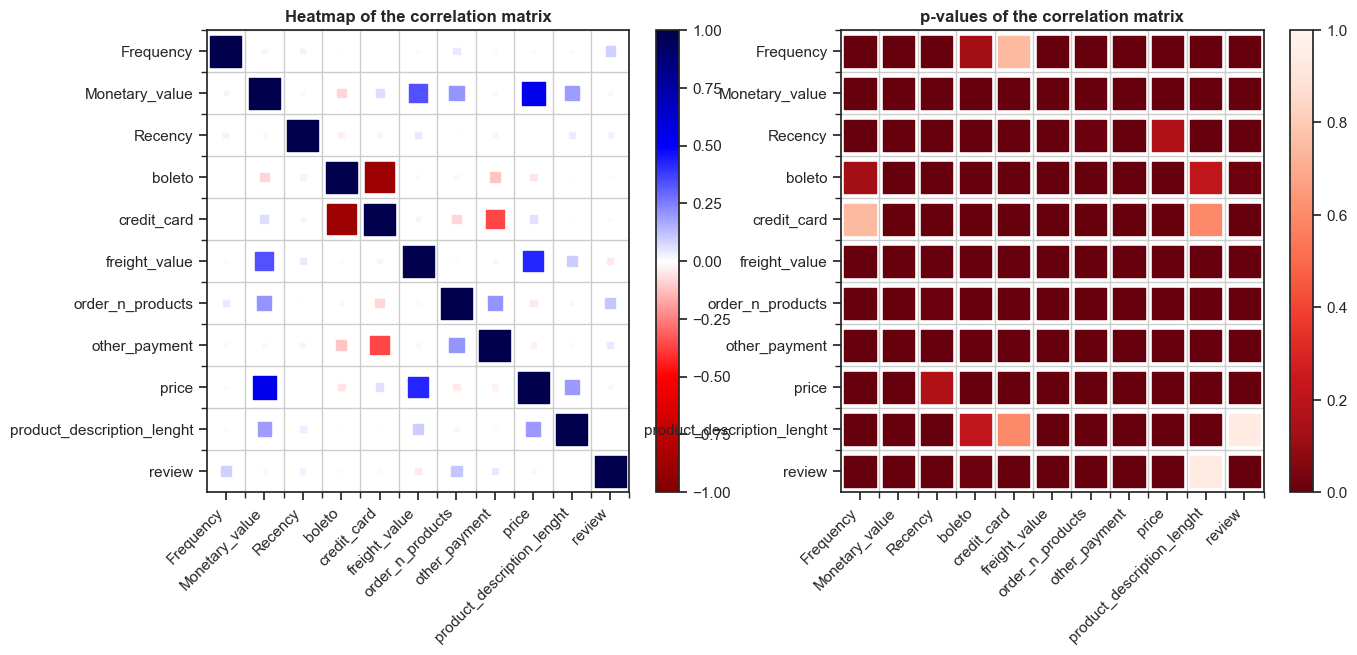

In [5]:
from functions.visualization import corr_plot

# Display the correlation array
corr_plot(df_clean, size_scale=500)

Nous remarquons que les moyens de paiement sont bien corrélées entre eux, ce n'est pas étonnant vu qu'il s'agit de proportion et que chaque transaction est payé avec un seul moyen de paiement.

Autre point notable et bien plus intéressant, c'est que la variable monétaire est bien plus corrélé au prix moyen du produit qu'au nombre de produits. Ce qui signifie que les clients ayant des paniers élevés **achètent des produits onéreux plus que des quantités importantes**.

## Clustering

### Clustering Hiérarchique

Pour débuter notre partitionnement nous allons utiliser une méthode hiérarchique agglomérative. Cette méthode est assez intuitive, elle consiste à considérer tous les points comme un cluster, puis à fusionner de manière itérative les clusters les plus proches jusqu'à en obtenir qu'un seul. Nous l'utiliserons afin d'avoir une idée du nombre de clusters à conserver. 

Pour savoir quels sont les clusters les plus proches il faut mesurer la distance qui les sépare. Pour cela l'algorithme a besoin de connaître deux paramètres :
- La métrique à utiliser
    - Euclidienne
    - Manhattan
    - Minkowski
    - Canberra
    - Cosinus
- La méthode à utiliser pout calculer la distance entre 2 clusters
    - lien simple (single linkage)
    - lien complet (complete linkage)
    - lien moyen (average linkage)
    - lien centroïdal (centroid linkage)
    - méthode de Ward
    
Pour la métrique cela dépendra du type de variable, si le jeu de données comporte uniquement des variables quantitatives (ce qui est notre cas) c'est la distance euclidienne qui sera utilisée. Pour un jeu de données hybride (variables quantitatives et qualitatives) ce sont les distances Manhattan ou Camberra qui seront préférées.

Les méthodes de lien définissent quels points des deux clusters utiliser pour calculer la distance. Ça peut être tous les points (average), les plus éloignés (complete), les centroïdes (centroid) ou les plus proches (single). Ces méthodes nous assurent des clusters bien éloignés, mais pas nécessairement homogènes. Ce qui est notamment problématique pour des jeux de données de petites tailles, car on risque de se retrouver avec des clusters comportant très peu d'individus (voire qu'un seul). Pour éviter cela nous pouvons utiliser la *méthode de Ward* qui, en cherchant à *minimiser la variance intraclasse*, permet d'obtenir des clusters bien plus homogènes. C'est pour cette raison que c'est celle qui est privilégiée en général, bien qu'elle demande plus de temps de calcul. Pour voir la différence entre une méthode de lien et la méthode de Ward, nous allons comparer le dendrogramme obtenu avec Ward au dendogramme obtenu avec un lien centroïdal.

Les méthodes de clustering agglomératif sont très gourmandes en terme de temps de calcul. C'est pourquoi, nous devrons réduire le nombre d'observations à l'aide d'un k-means (que nous verrons juste aprés) avant de lancer l'algorithme agglomératif.

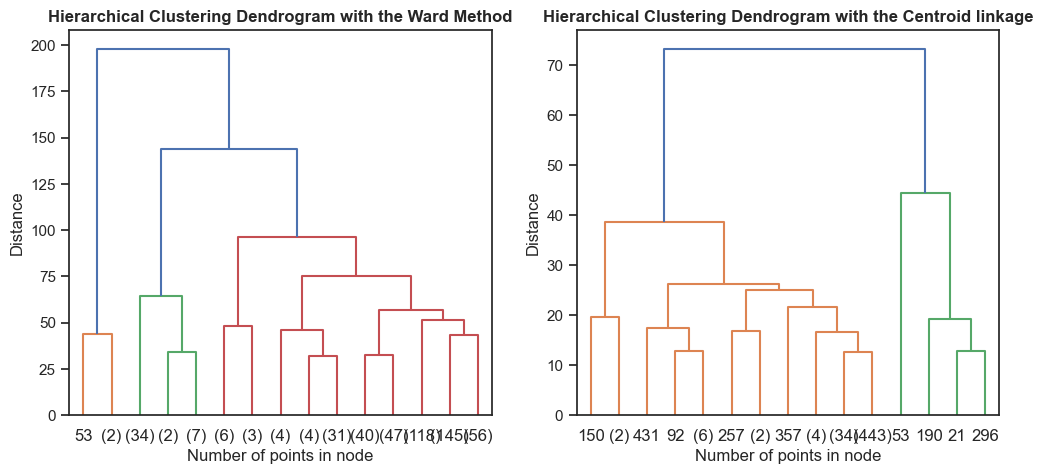

In [6]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans

# Reduce the number of samples with a k-means
X = df_clean.values
kmeans= KMeans(n_clusters=500, random_state=42)
kmeans.fit(X)
X_reduced = kmeans.cluster_centers_
# Create the linkage matrix
ward_linkage = linkage(X_reduced, method='ward',
                       metric='euclidean')
centroid_linkage = linkage(X_reduced, method='centroid',
                           metric='euclidean')
# Create the figure
plt.figure(figsize=(12, 5))
# Create the dendrogram with the ward method
ax1 = plt.subplot(121)
dendrogram(ward_linkage, truncate_mode='lastp', p=15)
ax1.set_xlabel("Number of points in node")
ax1.set_ylabel("Distance")
ax1.set_title("Hierarchical Clustering Dendrogram with the Ward Method")
# Create the dendrogram with the centroid linkage
ax2=plt.subplot(122)
dendrogram(centroid_linkage, truncate_mode='lastp', p=15)
ax2.set_xlabel("Number of points in node")
ax2.set_ylabel("Distance")
ax2.set_title("Hierarchical Clustering Dendrogram with the Centroid linkage")
# Save the plot
folder_path=os.path.join("charts")
if not os.path.isdir(folder_path):
    os.makedirs(folder_path)
plt.savefig("charts/corr_matrix.png")
plt.show()                  

Comme prévu on obtient des clusters plus homogènes avec la méthode de Ward que le lien centroïde. Le nombre intuitif de clusters devant être conservés est là aussi différent. Si nous sommes tentés de conserver trois clusters avec Ward, ça serait plutôt deux avec les centroïdes.

Le nombre de clusters optimal semble être situé entre 2 et 7 clusters.

Nous allons maintenant tester sur ces nombres de clusters les deux algorithmes de clustering les plus utilisés:
- k-means
- DBSCAN

Pour chaque algorithme le *nombre optimal* de clusters sera déterminé grâce au *coefficient de silhouette*.  
Le choix de l'algorithme se fera sur la *stabilité* des clusters, déterminé à l'aide du *coefficient de rand ajusté*.

### k-means

Nous commencerons par l'algorithme le plus utilisé, l'algorithme du *K-Mean*.  
Son fonctionnement est assez simple, l'utilisateur rentre le nombre de clusters souhaités (k) puis l'algorithme initialise le modèle en choisissant aléatoirement k points parmi les observations du jeu de données. Ces k points seront considérés comme des centroïdes, l'agorithme va ensuite voir pour chaque observation quel est le centroïde qui est le plus proche et ainsi pouvoir lui attribuer un cluster. Puis l'algorithme va calculer les nouveau centroïdes des clusters ainsi formés. Il va ensuite itérer le processus (formation des clusters, calcul des centroïdes) jusqu'à obtenir une convergence (les  centroïdes ne bougent plus).

Du fait de l'attribution aléatoire des premiers centroïdes les résultats peuvent ne pas être stables (clusters différents à chaque fois que l'algorithme est lancé). Le k-means étant l'un des algorithmes de clustering le plus rapide, il peut être utile de lancer l'algorithme plusieurs fois et ensuite de garder le modèle avec la meilleure inertie (petite inertie intra-cluster, grande inertie inter-cluster). C'est ce que permet l'option n_init de la classe **KMeans** de *sklearn.cluster*.

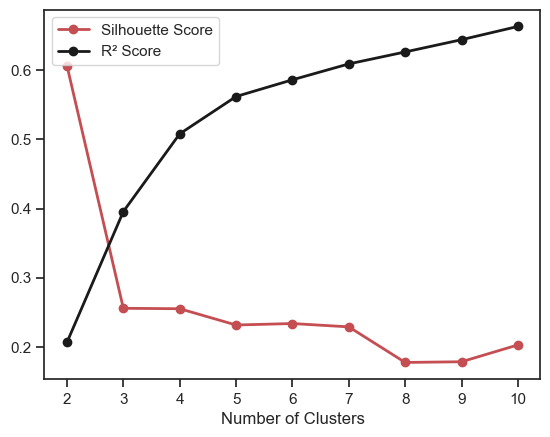

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = df_clean.values
total_inertia = np.var(X, axis=0).sum()
sample_size = int(X.shape[0]*0.2)
r2_scores = []
s_scores = []
for k in range(2, 11):
    kmeans= KMeans(n_clusters=k, init='k-means++',
                   n_init=10, random_state=42)
    kmeans.fit(X)
    # get the silhouette score
    s_scores.append(silhouette_score(X, kmeans.labels_,
                                     metric='euclidean',
                                     sample_size=sample_size,
                                     random_state=42))
    # get the R2 Score
    cluster, counts = np.unique(kmeans.labels_, return_counts=True)
    weights = pd.Series(counts, index=cluster, name="weight")/len(X)
    inter_inertia = (weights*((kmeans.cluster_centers_ - X.mean(axis=0))**2).sum(axis=1)).sum()
    r2_scores.append(inter_inertia/total_inertia)
plt.plot(range(2, 11), s_scores, "ro-", linewidth=2, label="Silhouette Score")    
plt.plot(range(2, 11), r2_scores, "ko-", linewidth=2, label="R² Score")
plt.xlabel("Number of Clusters")
plt.legend(loc="best")
plt.show()

### DBSCAN

### Clustering final

## Caractérisation des clusters

### Visualisation des clusters avec le t-SNE